(ttv)=

# Fitting for Transit Timing Variations (TTVs)

Similarly to `exoplanet`, `jaxoplanet` contains the ability to model transit timing variations for planetary systems. This tutorial follows from [Fitting Transit Times](https://gallery.exoplanet.codes/tutorials/ttv/) for the `exoplanet` package.

```{note}
This tutorial requires some [extra packages](about.ipynb) that are not included in the `jaxoplanet` dependencies.
```

## Setup

We first setup the number of CPUs to use and enable the use of double-precision numbers with jax. We also import the required packages.

In [1]:
import jax
import numpyro
from jaxoplanet.orbits.ttv import TTVOrbit, compute_expected_transit_times
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.light_curves import limb_dark_light_curve
import jax.numpy as jnp
from jaxoplanet.units import unit_registry as ureg

# For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_host_device_count(2)

# For CPU (use "gpu" for GPU)
numpyro.set_platform("cpu")

# For 64-bit precision since JAX defaults to 32-bit
jax.config.update("jax_enable_x64", True)

c:\Users\Tyler\miniconda3\envs\jaxoplanet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generating the data

Let's introduce our first new orbit object, `TTVOrbit`.

This is an orbit parameterized by the observables of a transiting system: speed/duration, impact parameter and radius ratio, but notably we can pass in a list of transit times to the `transit_times` keyword argument, omitting the need for a period and time of transit.


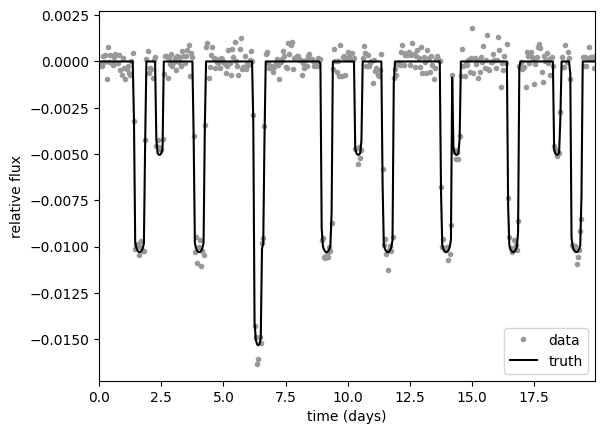

In [2]:
# Simulate some data with Gaussian noise
time = jnp.arange(0, 20, 0.05)  # day
random = np.random.default_rng(11)
PERIOD = random.uniform(2, 6, 2)  # day
T0 = PERIOD * random.uniform()  # day

# Compute the transit times for a linear ephemeris
OLD_TRANSIT_TIMES = compute_expected_transit_times(time.min(), time.max(), PERIOD, T0) 

# Compute the true TTVs
true_ttvs = [((3/24) - (i % 2) * 0.1) * np.sin(2 * np.pi * tt / 8) for i, tt in enumerate(OLD_TRANSIT_TIMES)] #Let's make the TTVs sinusoidal with a period of 17 days

# Add the TTVs to the transit times
TRANSIT_TIMES = [tt + v for tt, v in zip(OLD_TRANSIT_TIMES, true_ttvs)]

# Define the duration, impact parameter, radius ratio, and limb darkening coefficients
DURATION = jnp.array([0.5, 0.3])  
B = jnp.array([0.5, 0.5])  
ROR = jnp.array([0.1, 0.07]) 
U = jnp.array([0.1, 0.06]) 
yerr = 5e-4  


orbit = TTVOrbit(
    transit_times=TRANSIT_TIMES, duration=DURATION, time_transit=T0, impact_param=B, radius_ratio=ROR
)
y_true = jnp.sum(limb_dark_light_curve(orbit, U)(time), axis=-1) # Here, we sum the light curves of the two planets
y = jnp.array(y_true + yerr *  random.normal(size=len(time)))

# Let's see what the light curve looks like
plt.plot(time, y, ".", c="0.6", label="data")
plt.plot(time, y_true, "-k", label="truth")
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
_ = plt.legend(loc=4)


## Model with NumPyro

We're going to assume you have the basics about how to construct a model from the [Transit Fitting](transit.ipynb) tutorial... So let's show off how to parameterize the model with TTVs (and multi-planet systems).  

In [3]:
import numpyro_ext
import jax.numpy as jnp

'''
Note here, we DO NOT want to track the function outside of the model or we lose the ability to trace the ttv posterior. 
'''
# Note below, we model for 'TTVOrbit' rather than 'TransitOrbit'.
#def light_curve_model(time, params):
#    orbit = TTVOrbit(
#        transit_times=params["transit_times"],
#        duration=params["duration"],
#        impact_param=params["b"],
#        radius_ratio=params["r"],
#    )
#    return limb_dark_light_curve(orbit, params["u"])(time)


def model(t, yerr, y=None):

    # For loop to account for each planet's transit times, with a Normal prior centered on the true transit times and an uncertianty of 1. 
    transit_times = []
    for i in range(2):
        transit_times.append(numpyro.sample(f"transit_times_{i}", numpyro.distributions.Normal(TRANSIT_TIMES[i], 1.0)))
    
    # The duration
    logD = numpyro.sample("logD", numpyro.distributions.Normal(jnp.log(DURATION), 0.1).to_event(1))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # The radius ratio
    logR = numpyro.sample("logR", numpyro.distributions.Normal(jnp.log(ROR), 0.1).to_event(1))
    r = numpyro.deterministic("r", jnp.exp(logR))

    # The impact parameter, note, for multi-planet systems, we need to pass in a jax numpy array of values
    _b = numpyro.sample("_b", numpyro.distributions.Uniform(low=jnp.array([0.0, 0.0]), high=jnp.array([1.0, 1.0])).to_event(1))
    b = numpyro.deterministic("b", _b * (1 + r))

    # The limb darkening coefficients
    u = numpyro.sample("u", numpyro_ext.distributions.QuadLDParams())

    # The orbit and light curve
    orbit = TTVOrbit(
        transit_times=transit_times,
        duration=duration,
        impact_param=b,
        radius_ratio=r,
    )
    y_pred = jnp.sum(limb_dark_light_curve(orbit, u)(time), axis=-1)
    
    # We are going to track the individual light curves for some plotting usages
    numpyro.deterministic("light_curve_single", limb_dark_light_curve(orbit, u)(time))
    

    # Here are some useful under the radar variables that we can access from TTVOrbit. These are the linear ephemeris parameters and the TTVs.
    for i in range(2):
        numpyro.deterministic(f"t0_{i}", orbit.linear_t0[i])
        numpyro.deterministic(f"period_{i}", orbit.linear_period[i])
        numpyro.deterministic(f"ttvs_{i}", orbit.ttvs[i])
    



    # Let's track the light curve
    numpyro.deterministic("light_curve", y_pred)

    # The likelihood function assuming Gaussian uncertainty
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

## Checking the priors

Following from the transit tutorial, let's check the priors using the `numpyro.infer` submodule's `Predictive` functionality to draw some samples from the priors. 





In [4]:
import arviz as az

n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), time, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

array([[<Axes: title={'center': 'transit_times_0'}>,
        <Axes: title={'center': 'transit_times_0'}>],
       [<Axes: title={'center': 'transit_times_1'}>,
        <Axes: title={'center': 'transit_times_1'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'r'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'u'}>, <Axes: title={'center': 'u'}>]],
      dtype=object)

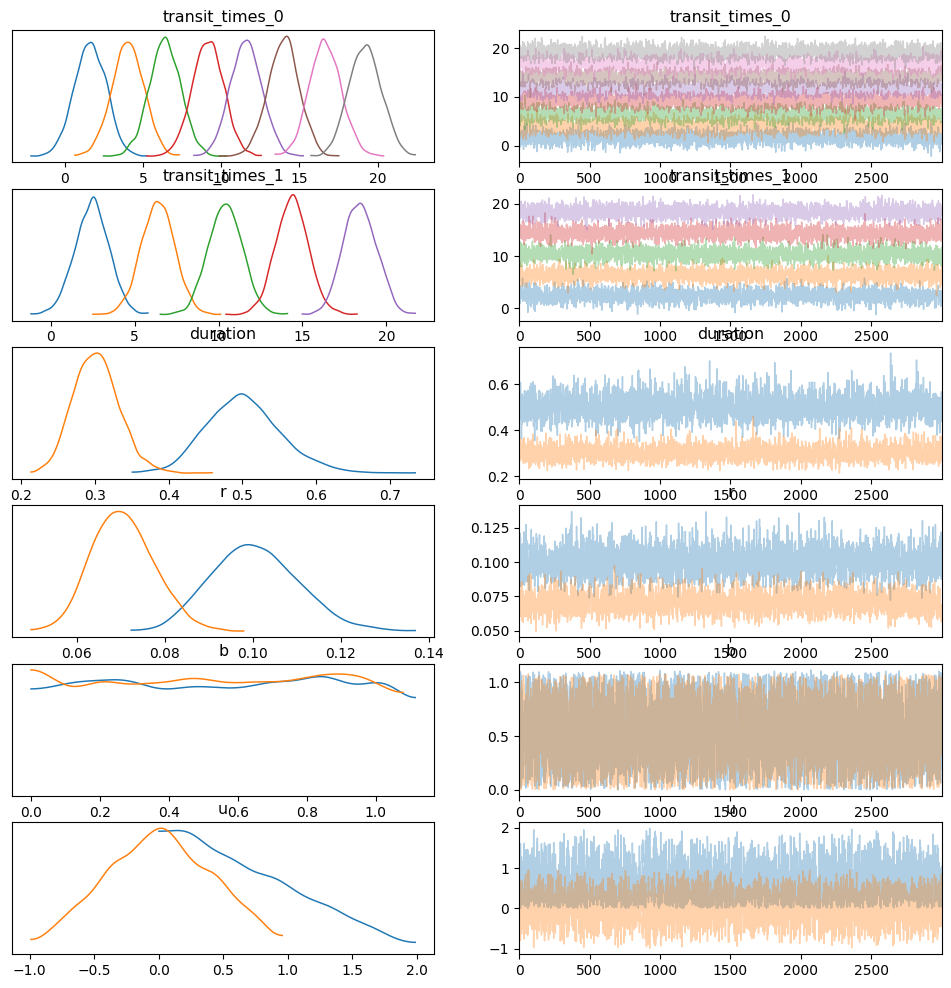

In [5]:
az.plot_trace(prior_samples_inf_data, var_names=["transit_times_0", "transit_times_1", "duration", "r", "b", "u"])


We can see that the individual transit times are also shown in each planet's trace.

We'll use the `optimize` function defined within the `numpyro_ext` package. 

Let's set the initial values to the true values. 
<!-- Let's do the latter and set the initial values to the median values of the priors. -->

In [6]:
init_param_method = "true_values"  # "prior_median" or "true_values"

if init_param_method == "prior_median":
    print("Starting from the prior medians")
    run_optim = numpyro_ext.optim.optimize(
        model, init_strategy=numpyro.infer.init_to_median()
    )
elif init_param_method == "true_values":
    print("Starting from the true values")
    init_params = {
        "transit_times_0": TRANSIT_TIMES[0],
        "transit_times_1": TRANSIT_TIMES[1],
        "logD": jnp.log(DURATION),
        "logR": jnp.log(ROR),
        "_b": B / (1 + ROR),
        "u": U,
    }
    run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
    )

opt_params = run_optim(jax.random.PRNGKey(5), time, yerr, y=y)

Starting from the true values


Now let's plot the MAP model against the simulated data.

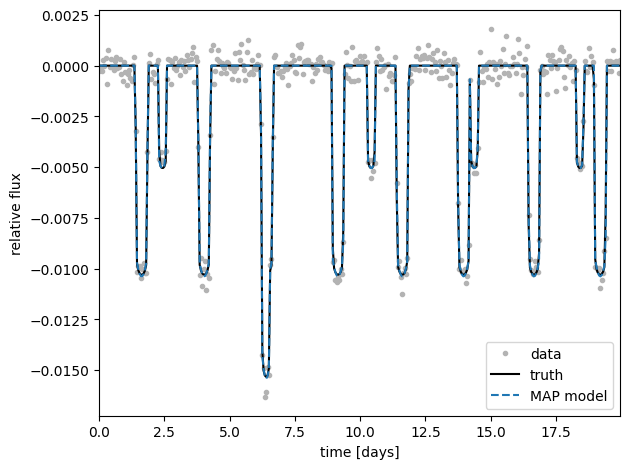

In [7]:
plt.plot(time, y, ".", c="0.7", label="data")
plt.plot(time, y_true, "-k", label="truth")
plt.plot(time, opt_params["light_curve"], "--C0", label="MAP model")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.legend(fontsize=10, loc=4)
plt.xlim(time.min(), time.max())
plt.tight_layout()

Looks good!

We are now going to have a quick look at the individual phase plots to demonstrate the issue with phasing planets exhibiting TTVs (which TTVOrbit corrects under the hood).


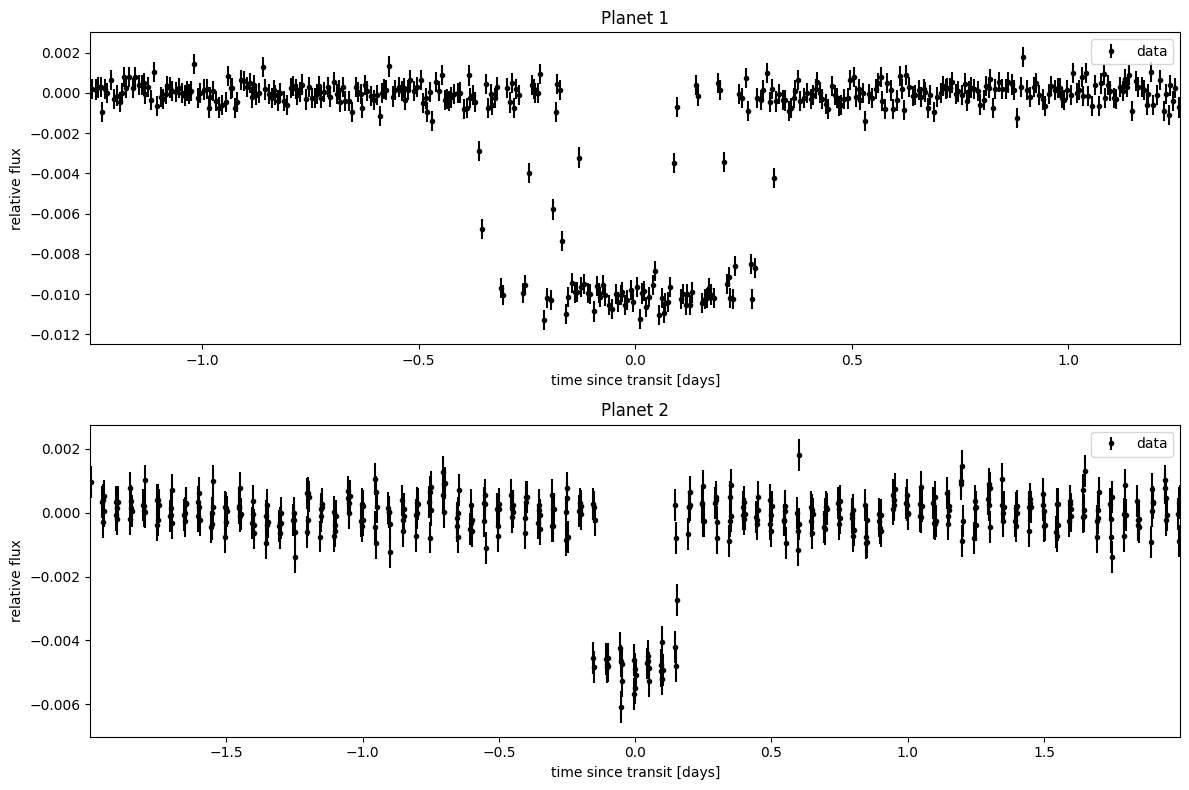

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Get the posterior median orbital parameters
p_1 = opt_params["period_0"]
t0_1 = opt_params["t0_0"]
lc_1 = opt_params["light_curve_single"][:, 0]
p_2 = opt_params["period_1"]
t0_2 = opt_params["t0_1"]
lc_2 = opt_params["light_curve_single"][:, 1]

# Plot the folded data
x_fold_1 = (time - t0_1 + 0.5 * p_1) % p_1 - 0.5 * p_1
x_fold_2 = (time - t0_2 + 0.5 * p_2) % p_2 - 0.5 * p_2


ax[0].errorbar(x_fold_1, y-lc_2, yerr=yerr, fmt=".k", label="data", zorder=-1000)
ax[0].set_xlim(-0.5 * p_1, 0.5 * p_1)
ax[0].set_xlabel("time since transit [days]")
ax[0].set_ylabel("relative flux")
ax[0].set_title("Planet 1")
ax[0].legend()
ax[1].errorbar(x_fold_2, y-lc_1, yerr=yerr, fmt=".k", label="data", zorder=-1000)
ax[1].set_xlim(-0.5 * p_2, 0.5 * p_2)
ax[1].set_xlabel("time since transit [days]")
ax[1].set_ylabel("relative flux")
ax[1].set_title("Planet 2")
ax[1].legend()
plt.tight_layout()
plt.show()



That obviously doesn't look great! But this is why we need to account for the TTVs, which 'TTVOrbit' corrects under the hood.


## Sampling
Let's sample from the posterior.

In [9]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=False, # or OMIT... for some reason unknown to me, when dense_mass is true, the sampler breaks down. 
        regularize_mass_matrix=False,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1), time, yerr, y=y)

Running chain 0:   0%|          | 0/3000 [00:10<?, ?it/s]

In [10]:
inf_data = az.from_numpyro(sampler)
samples = sampler.get_samples()
az.summary(inf_data, var_names=["transit_times_0", "transit_times_1", "duration", "r", "b", "u"])

Running chain 0: 100%|██████████| 3000/3000 [02:25<00:00, 20.62it/s]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
transit_times_0[0],1.627,0.001,1.624,1.630,0.000,0.000,3222.0,2483.0,1.00
transit_times_0[1],4.024,0.001,4.021,4.027,0.000,0.000,3532.0,2423.0,1.00
transit_times_0[2],6.426,0.002,6.423,6.429,0.000,0.000,2990.0,1917.0,1.00
transit_times_0[3],9.147,0.003,9.142,9.152,0.000,0.000,4453.0,2723.0,1.00
transit_times_0[4],11.614,0.002,11.611,11.618,0.000,0.000,1930.0,1260.0,1.00
transit_times_0[5],13.961,0.002,13.958,13.965,0.000,0.000,2038.0,1431.0,1.00
transit_times_0[6],16.658,0.003,16.653,16.663,0.000,0.000,1921.0,1633.0,1.00
transit_times_0[7],19.195,0.003,19.190,19.200,0.000,0.000,3715.0,2703.0,1.00
transit_times_1[0],2.424,0.008,2.410,2.439,0.000,0.000,1909.0,3162.0,1.00
transit_times_1[1],6.376,0.007,6.363,6.389,0.000,0.000,2454.0,2827.0,1.00


We can typically plot traces using the `plot_trace` function in the `Arviz` package, but in this instance we have to reshape the samples to be of shape (chains, draws, *shape) rather than (chains, *shape).

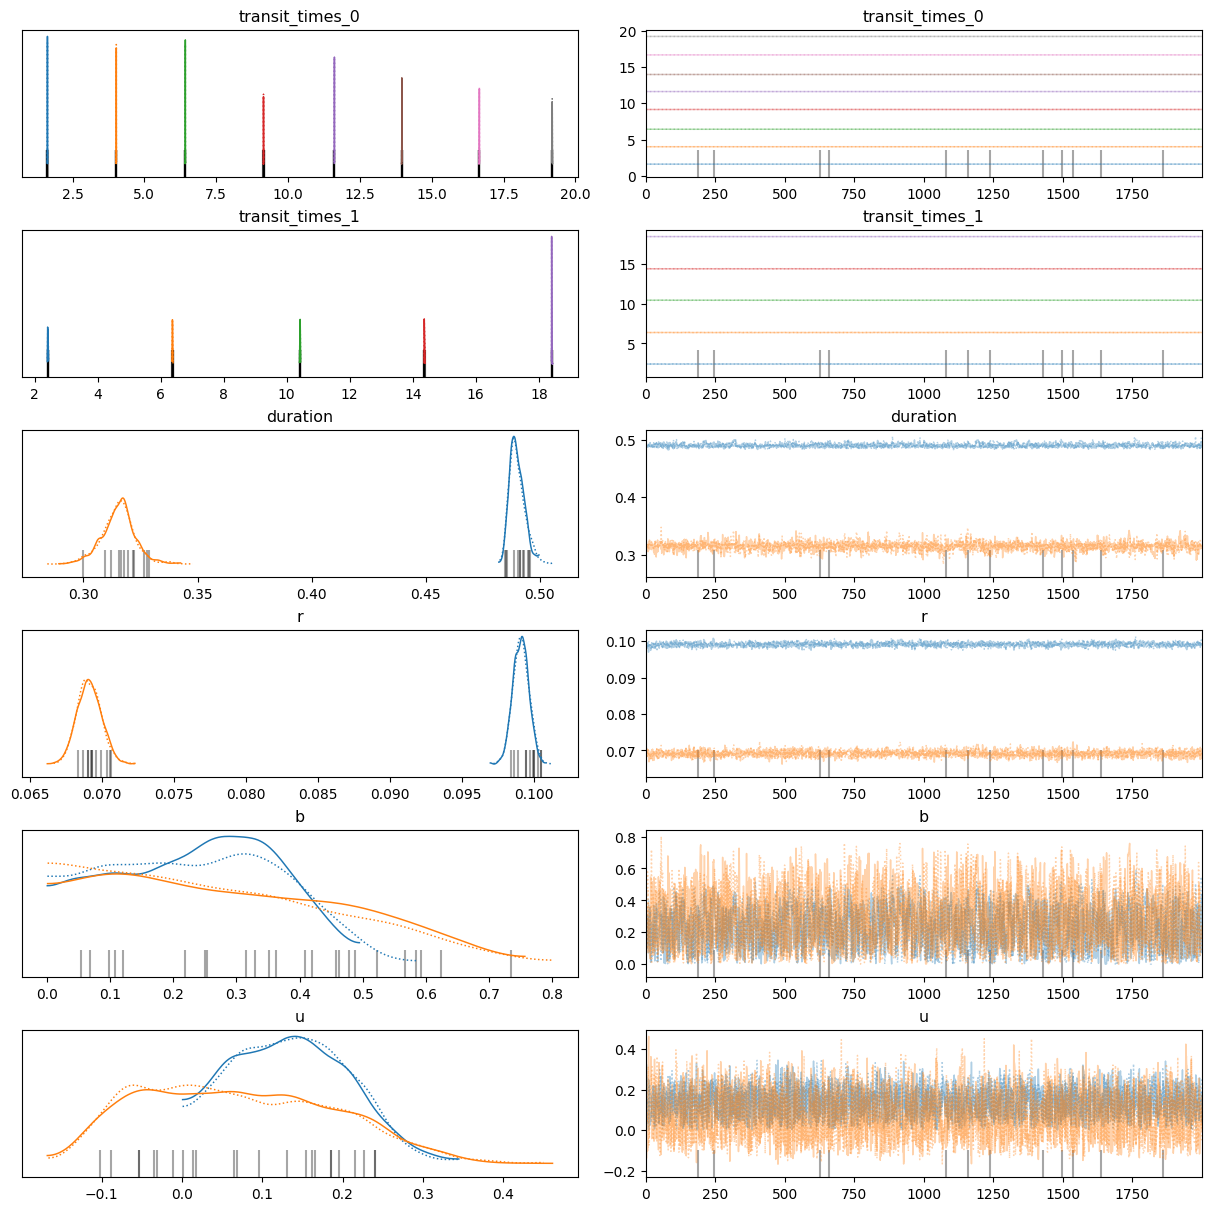

In [11]:
az.plot_trace(
    inf_data,
    var_names=["transit_times_0", "transit_times_1", "duration", "r", "b", "u"],
    backend_kwargs={"constrained_layout": True},
            )
plt.show()


# TTV Plots

lets make some TTV plots to show we correctly identified the trend!

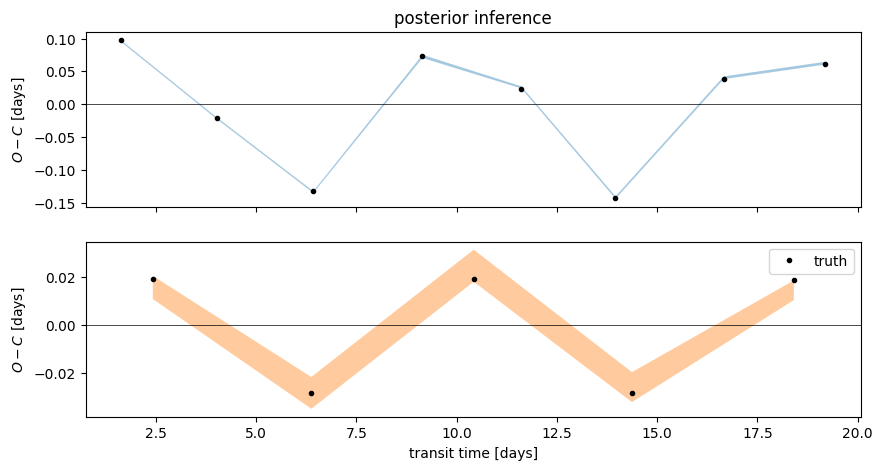

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

q = np.percentile(samples["ttvs_0"], [16, 50, 84], axis=0)


ax1.fill_between(
    np.mean(samples["transit_times_0"], axis=0),
    q[0],
    q[2],
    color="C0",
    alpha=0.4,
    edgecolor="none",
)
ref = np.polyval(
    np.polyfit(TRANSIT_TIMES[0], true_ttvs[0], 1), TRANSIT_TIMES[0]
)
ax1.plot(TRANSIT_TIMES[0], true_ttvs[0] - ref, ".k")
ax1.axhline(0, color="k", lw=0.5)
#ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(samples["ttvs_1"], [16, 50, 84], axis=0)
ax2.fill_between(
    np.mean(samples["transit_times_1"], axis=0),
    q[0],
    q[2],
    color="C1",
    alpha=0.4,
    edgecolor="none",
)
ref = np.polyval(
    np.polyfit(TRANSIT_TIMES[1], true_ttvs[1], 1), TRANSIT_TIMES[1]
)
ax2.plot(TRANSIT_TIMES[1], true_ttvs[1] - ref, ".k", label="truth")
ax2.axhline(0, color="k", lw=0.5)
#ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))

ax2.legend(fontsize=10)
ax2.set_ylabel("$O-C$ [days]")
ax2.set_xlabel("transit time [days]")
_ = ax1.set_title("posterior inference")


# Success!

We can see the posterior is correctly predicting the true ttvs to a great level! 